In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
plt.style.use('seaborn')
import copy
import warnings
warnings.filterwarnings("ignore")

/Users/regan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-a821b52fd5e8>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

### Feature Engineering 

In [3]:
def add_features(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)
    df['month_start'] = (df['date'].dt.is_month_start).astype(int)
    df['month_end'] = (df['date'].dt.is_month_end).astype(int)
    # Assume you have a holiday series to merge with the dataset for holiday feature
    # df = df.merge(holidays, on='date', how='left')
    # df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)

    # Aggregations
    df['daily_avg'] = df.groupby(['item', 'store', 'dayofweek'])['sales'].transform('mean')
    df['monthly_avg'] = df.groupby(['item', 'store', 'month'])['sales'].transform('mean')
    df['item_month_sum'] = df.groupby(['month', 'item'])['sales'].transform('sum')
    df['store_month_sum'] = df.groupby(['month', 'store'])['sales'].transform('sum')
    
    lag_365 = df[["date", "sales", "store", "item"]]
    lag_365["date"] += pd.Timedelta("364 days")
    lag_365.columns =["date", "lag_12mo", "store", "item"]
    df = df.merge(lag_365, on=["date", "store", "item"])

    # Lagged Features
    for lag in [1, 7, 30, 365]:
        lag_col_name = f"lag_{lag}d"
        df[lag_col_name] = df.groupby(['item', 'store'])['lag_12mo'].shift(periods=lag)

    # Rolling window features
    df['rolling_mean_7'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=7).mean())
    df['rolling_mean_30'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=30).mean())
    df['rolling_std_7'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=7).std())
    df['rolling_std_30'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=30).std())
    return df

In [4]:
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    
    model=xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                  ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)

    return model,matrix_train,matrix_test

# model,matrix_train,matrix_test = XGBmodel(x_train,x_test,y_train,y_test)

In [5]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def XGB_results(model, matrix_train, matrix_test, y_train, y_test):
    # Train predictions
    preds_train = model.predict(matrix_train)
    # RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
    print(f'Test RMSE: {rmse_train: 3f}')
    # SMAPE
    smape_val_train = smape(y_train, preds_train)
    print(f'Test SMAPE: {smape_val_train: 3f}')
    
    
    # Test predictions
    preds_test = model.predict(matrix_test)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds_test))
    print(f'Test RMSE: {rmse: 3f}')
    # SMAPE
    smape_val = smape(y_test, preds_test)
    print(f'Test SMAPE: {smape_val: 3f}')

### Model Training

In [6]:
df_train = add_features(train)
df_train.head()

,date,store,item,sales,year,month,dayofweek,quarter,is_weekend,month_start,...,store_month_sum,lag_12mo,lag_1d,lag_7d,lag_30d,lag_365d,rolling_mean_7,rolling_mean_30,rolling_std_7,rolling_std_30
0,2013-12-31,1,1,15,2013,12,1,4,0,0,...,276349,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,1,1,9,2014,1,2,1,0,1,...,249352,11,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-02,1,1,14,2014,1,3,1,0,0,...,249352,14,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-03,1,1,11,2014,1,4,1,0,0,...,249352,13,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-04,1,1,20,2014,1,5,1,1,0,...,249352,10,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

# Add features
df_train = add_features(train)
# split train and validation sets
df_test = df_train[df_train["date"] >= "2017-10-01"]
df_train = df_train[df_train["date"] < "2017-10-01"]

print(df_train.shape)
print(df_test.shape)

x_train = df_train.drop(columns=["sales", "date"])
y_train = df_train["sales"]
x_test = df_test.drop(columns=["sales", "date"])
y_test = df_test["sales"]

(685000, 24)
(46000, 24)


In [8]:
# Base params
params = {'max_depth': 2,
 'min_child_weight': 2,
 'gamma': 1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'learning_rate': 0.01,
 'n_estimators': 1000
}

matrix_train = xgb.DMatrix(x_train,label=y_train)
matrix_test = xgb.DMatrix(x_test,label=y_test)

evals = [(matrix_train, 'train'), (matrix_test, 'test')]

model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train)

preds_train = model.predict(x_train)
preds = model.predict(x_test)
y_true = df_test.sales.values

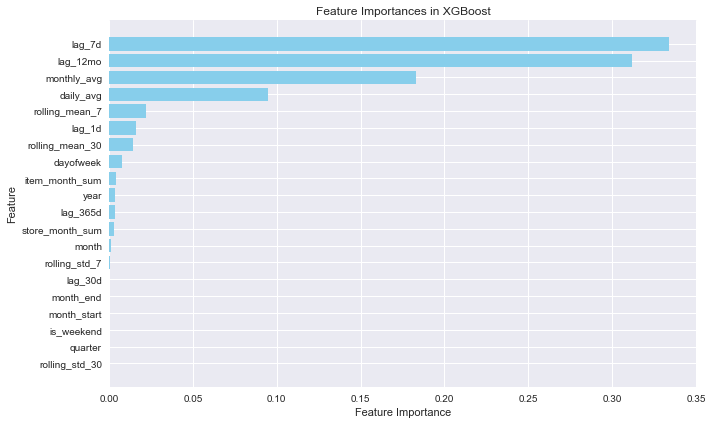

In [9]:
# Get feature importances
feature_importances = model.feature_importances_[2:]

# Get feature names
feature_names = x_train.columns.tolist()[2:]

# Sort the feature importances in descending order and match them with their names
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in XGBoost")
plt.barh(range(len(feature_importances)), feature_importances[indices], align='center', color='skyblue')
plt.yticks(range(len(feature_importances)), sorted_feature_names)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [10]:
y_train.values

array([ 15,   9,  14, ...,  82,  90, 103])

In [11]:
untuned_smape_train = smape(y_train.values, preds_train)
untuned_smape = smape(y_true, preds)

In [12]:
print(f"TRAIN SMAPE for untuned XGBoost model is : {untuned_smape_train:.2f}%")
print(f"TEST SMAPE for untuned XGBoost model is: {untuned_smape:.2f}%")

TRAIN SMAPE for untuned XGBoost model is : 12.94%
TEST SMAPE for untuned XGBoost model is: 12.97%


###  Hyperparameter Tuning

In [13]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def objective(trial, X, y, n_splits=5):
    param = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_categorical('max_depth', [4, 5, 6]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 2, 3, 4, 5]),
        'gamma': trial.suggest_categorical('gamma', [0.5, 2, 4, 6, 8, 10]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1, 1.5]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.2]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.1, 0.2]),
        'n_estimators': trial.suggest_categorical('n_estimators', [750, 1000])
    }

    rmse_sum = 0
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
        preds = model.predict(X_test)
        rmse_sum += np.sqrt(mean_squared_error(y_test, preds))

    average_rmse = rmse_sum / n_splits
    return average_rmse

def tune_xgb_hyperparameters(X, y, n_trials=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    trial = study.best_trial
    print(f"Best trial: RMSE {trial.value}")
    print("Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")
    
    best_params = trial.params
    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y)
    
    return best_model, best_params

# df_train = add_features2(train, important_features)
# x_train = df_train.drop(columns=["sales", "date"])
# y_train = df_train["sales"]
# best_xgb_model, best_params = tune_xgb_hyperparameters(x_train, y_train)

In [14]:
# import optuna
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error

# def objective(trial, X_train, y_train, X_test, y_test):
#     param = {
#         'booster': 'gbtree',
#         'objective': 'reg:squarederror',
#         'max_depth': trial.suggest_categorical('max_depth', [4, 5, 6]),
#         'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 2, 3, 4, 5]),
#         'gamma': trial.suggest_categorical('gamma', [0.5, 1, 2, 3, 4, 6]),
#         'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
#         'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1, 1.5, 2]),
#         'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.2, 0.3, 0.4]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.1, 0.2, 0.05]),
#         'n_estimators': trial.suggest_categorical('n_estimators', [750, 1000])
#     }

#     model = XGBRegressor(**param)
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
    
#     preds = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))
    
#     return rmse

# def tune_xgb_hyperparameters(X_train, y_train, X_test, y_test, n_trials=100):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)
    
#     trial = study.best_trial
    
#     print(f"Best trial: RMSE {trial.value}")
#     print("Best hyperparameters:")
#     for key, value in trial.params.items():
#         print(f"  {key}: {value}")
    
#     best_params = trial.params
#     best_model = XGBRegressor(**best_params)
#     best_model.fit(X_train, y_train)
    
#     return best_model, best_params

# # You can then call this function using your data:
# # best_xgb_model, best_params = tune_xgb_hyperparameters(x_train, y_train, x_test, y_test)


best_params = {'max_depth': 6,
 'min_child_weight': 3,
 'gamma': 4,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'learning_rate': 0.05,
 'n_estimators': 1000}

In [15]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

def calculate_permutation_importance(model, X_val, y_val, feature_names):
    # Perform permutation importance
    results = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Map the importances to the feature names and sort them
    importance_dict = {feature_names[i]: value for i, value in enumerate(results.importances_mean)}
    sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
    
    # Return the sorted feature importance
    return sorted_importance

# # Assuming X_val and y_val are your validation sets
# # And your model has been trained and is named 'model'
# feature_importances = calculate_permutation_importance(model, x_test, y_test, feature_names=x_train.columns.tolist())

# # Set your threshold for feature importance, this is arbitrary and can be set based on domain knowledge or experimentation
# importance_threshold = 0.001  # Example threshold

# # Filter the features by importance threshold
# important_features = [feature for feature, importance in feature_importances if importance > importance_threshold]

# print(f"Important features above the threshold: {important_features}")

def add_features2(df, important_features):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)
    df['month_start'] = (df['date'].dt.is_month_start).astype(int)
    df['month_end'] = (df['date'].dt.is_month_end).astype(int)
    # Assume you have a holiday series to merge with the dataset for holiday feature
    # df = df.merge(holidays, on='date', how='left')
    # df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)

    # Aggregations
    df['daily_avg'] = df.groupby(['item', 'store', 'dayofweek'])['sales'].transform('mean')
    df['monthly_avg'] = df.groupby(['item', 'store', 'month'])['sales'].transform('mean')
    df['item_month_sum'] = df.groupby(['month', 'item'])['sales'].transform('sum')
    df['store_month_sum'] = df.groupby(['month', 'store'])['sales'].transform('sum')
    
    lag_365 = df[["date", "sales", "store", "item"]]
    lag_365["date"] += pd.Timedelta("364 days")
    lag_365.columns =["date", "lag_12mo", "store", "item"]
    df = df.merge(lag_365, on=["date", "store", "item"])

    # Lagged Features
    for lag in [1, 7, 30, 365]:
        lag_col_name = f"lag_{lag}d"
        df[lag_col_name] = df.groupby(['item', 'store'])['lag_12mo'].shift(periods=lag)

    # Rolling window features
    df['rolling_mean_7'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=7).mean())
    df['rolling_mean_30'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=30).mean())
    df['rolling_std_7'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=7).std())
    df['rolling_std_30'] = df.groupby(['item', 'store'])['lag_12mo'].transform(lambda x: x.rolling(window=30).std())

    
    df_filtered = df[['date', 'store', 'item', 'sales']+ important_features]
    
    return df_filtered

### Calculate SMAPE

In [16]:
best_params = {'max_depth': 6,
 'min_child_weight': 3,
 'gamma': 4,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'learning_rate': 0.1,
 'n_estimators': 1000}

important_features = ['year',
 'dayofweek',
 'daily_avg',
 'monthly_avg',
 'lag_7d',
 'lag_365d',
 'rolling_mean_7',
 'rolling_mean_30',
 'lag_12mo']

In [17]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')

df_train = add_features2(train, important_features)

# split train and validation sets
df_test = df_train[df_train["date"] >= "2017-10-01"]
df_train = df_train[df_train["date"] < "2017-10-01"]

print(df_train.shape)
print(df_test.shape)

x_train = df_train.drop(columns=["sales", "date"])
y_train = df_train["sales"]
x_test = df_test.drop(columns=["sales", "date"])
y_test = df_test["sales"]

(685000, 13)
(46000, 13)


In [18]:
matrix_train = xgb.DMatrix(x_train,label=y_train)
matrix_test = xgb.DMatrix(x_test,label=y_test)

evals = [(matrix_train, 'train'), (matrix_test, 'test')]

model = xgb.XGBRegressor(**best_params)
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

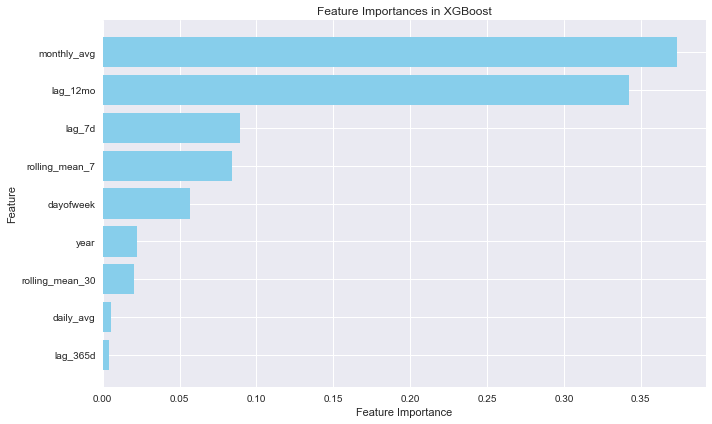

In [19]:
# Get feature importances
feature_importances = model.feature_importances_[2:]

# Get feature names
feature_names = x_train.columns.tolist()[2:]

# Sort the feature importances in descending order and match them with their names
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in XGBoost")
plt.barh(range(len(feature_importances)), feature_importances[indices], align='center', color='skyblue')
plt.yticks(range(len(feature_importances)), sorted_feature_names)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [20]:
pred_train = model.predict(x_train).round().astype(int).tolist()
pred = model.predict(x_test).round().astype(int).tolist()

true_pred_train = y_train.values
true_pred = df_test.sales.values

xgb_smape_train = smape(true_pred_train, pred_train)
xgb_smape = smape(true_pred, pred)

print(f"TRAIN SMAPE for XGBoost is: {xgb_smape_train:.2f}%")
print(f"TEST SMAPE for XGBoost is: {xgb_smape:.2f}%")

TRAIN SMAPE for XGBoost is: 11.93%
TEST SMAPE for XGBoost is: 12.21%


### Prediction

In [21]:
test = pd.read_csv('demand-forecasting-kernels-only/test.csv')
test = test.drop(columns=['id'])

df = pd.concat([train, test])
df

,date,store,item,sales,year,month,dayofweek,quarter,is_weekend,month_start,month_end,daily_avg,monthly_avg,item_month_sum,store_month_sum
0,2013-01-01 00:00:00,1,1,13.0,2013.0,1.0,1.0,1.0,0.0,1.0,0.0,18.168582,13.709677,22987.0,249352.0
1,2013-01-02 00:00:00,1,1,11.0,2013.0,1.0,2.0,1.0,0.0,0.0,0.0,18.793103,13.709677,22987.0,249352.0
2,2013-01-03 00:00:00,1,1,14.0,2013.0,1.0,3.0,1.0,0.0,0.0,0.0,19.452107,13.709677,22987.0,249352.0
3,2013-01-04 00:00:00,1,1,13.0,2013.0,1.0,4.0,1.0,0.0,0.0,0.0,21.015326,13.709677,22987.0,249352.0
4,2013-01-05 00:00:00,1,1,10.0,2013.0,1.0,5.0,1.0,1.0,0.0,0.0,22.973180,13.709677,22987.0,249352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44996,2018-03-28,10,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44997,2018-03-29,10,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44998,2018-03-30,10,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
best_params = {'max_depth': 6,
 'min_child_weight': 3,
 'gamma': 4,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'learning_rate': 0.1,
 'n_estimators': 1000}

important_features = ['year',
 'dayofweek',
 'daily_avg',
 'monthly_avg',
 'lag_7d',
 'lag_365d',
 'rolling_mean_7',
 'rolling_mean_30',
 'lag_12mo']

In [23]:
# need train set to add features to the test dataset
df = add_features2(df, important_features)
df.tail()

,date,store,item,sales,year,dayofweek,daily_avg,monthly_avg,lag_7d,lag_365d,rolling_mean_7,rolling_mean_30,lag_12mo
775995,2018-03-27,10,50,NaN,2018,1,67.777778,67.780645,60.0,51.0,69.000000,72.800000,60.0
775996,2018-03-28,10,50,NaN,2018,2,68.823755,67.780645,57.0,73.0,71.285714,73.533333,73.0
775997,2018-03-29,10,50,NaN,2018,3,73.532567,67.780645,67.0,68.0,71.428571,73.733333,68.0
775998,2018-03-30,10,50,NaN,2018,4,78.275862,67.780645,73.0,75.0,70.857143,73.500000,69.0
775999,2018-03-31,10,50,NaN,2018,5,82.854406,67.780645,79.0,83.0,74.000000,74.266667,101.0


In [24]:
df = df[df['date'] >= "2018-01-01"]
df = df.drop(columns=['sales','date'])

In [25]:
df

,store,item,year,dayofweek,daily_avg,monthly_avg,lag_7d,lag_365d,rolling_mean_7,rolling_mean_30,lag_12mo
731000,1,1,2018,0,15.584615,13.709677,16.0,12.0,17.000000,16.233333,15.0
731001,1,1,2018,1,18.168582,13.709677,10.0,12.0,17.000000,15.766667,10.0
731002,1,1,2018,2,18.793103,13.709677,16.0,12.0,17.000000,15.866667,16.0
731003,1,1,2018,3,19.452107,13.709677,21.0,16.0,16.000000,16.000000,14.0
731004,1,1,2018,4,21.015326,13.709677,24.0,12.0,16.000000,16.233333,24.0
...,...,...,...,...,...,...,...,...,...,...,...
775995,10,50,2018,1,67.777778,67.780645,60.0,51.0,69.000000,72.800000,60.0
775996,10,50,2018,2,68.823755,67.780645,57.0,73.0,71.285714,73.533333,73.0
775997,10,50,2018,3,73.532567,67.780645,67.0,68.0,71.428571,73.733333,68.0
775998,10,50,2018,4,78.275862,67.780645,73.0,75.0,70.857143,73.500000,69.0


In [26]:
predictions = model.predict(df)

In [27]:
len(predictions)

45000

In [28]:
with open("submission.csv", "w") as file:
    file.write("id,sales\n")
    count = 0
    for prediction in predictions:
        file.write(str(count) + ',')
        file.write(str(int(prediction)) + "\n")
        count += 1